## FIGURE: identification results for corrugated molecules
We want to try check if we can correctly identify highly corrugated molecules

In [85]:
def morgan_fp_gen(smiles, nBits=2048):
    m1 = AllChem.MolFromSmiles(smiles)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(m1,2,nBits=nBits)
    return np.array(fp1)

def load_exp_img_stack(path, dimensions=[224,224], zoom=1, normalize=True, interpolation='bilinear'):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:
        
        im_list.append(Image.open(im_path).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = 0
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    #normalize = transforms.Normalize(
    #    mean=[0.1321, 0.1487, 0.1689, 0.1983, 0.2229, 0.2591, 0.3430, 0.4580, 0.5787, 0.6887],
    #    std=[0.0853, 0.0853, 0.0883, 0.0942, 0.0969, 0.1066, 0.1419, 0.1840, 0.2144, 0.2215]) #this is for K-1

    
    if normalize:

        normalize = transforms.Normalize(
            mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
            std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders

        tensor_stack = normalize(tensor_stack)

    return tensor_stack

def load_jmol_image(cid, dimension=[224,224], zoom=1):
    if USER=='manuel':
        path = f'/home/{USER}/QUAM-AFM/QUAM/JMOL_IMAGES/{cid}/{cid}.png' ##Mustang
    else:
        path = f'/scratch/dataset/quam/JMOL_IMAGES/{cid}/{cid}.png' ##Rocinante
    jmol_image = Image.open(path)
     # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    
    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))
    
    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)
    
    return jmol_image_array

def _extract_cid(path):
    return int(path.split('_')[-3])

def run_prediction(molec_path, dimension=[224,224], zoom=1, verbose=False, zoom_jmol = None):
    img_stack = load_img_stack(molec_path, zoom=zoom)
    true_CID = _extract_cid(molec_path)

    fp_pred = predict_fp(model, molec_path, device,  thres = 0.5)

    output_df = fp_screening_function(fp_pred, test_df, top_k = 5, int_type=np.int8)


    pred_CID = _extract_cid(output_df.iloc[0]['path'])
    tanimoto = output_df.iloc[0]['tanimoto']
    if zoom_jmol is not None:
        gt_jmol = load_jmol_image(true_CID, dimension=dimension, zoom=zoom_jmol)
        pred_jmol = load_jmol_image(pred_CID, dimension=dimension, zoom=zoom_jmol)
    else:
        gt_jmol = load_jmol_image(true_CID, dimension=dimension, zoom=zoom)
        pred_jmol = load_jmol_image(pred_CID, dimension=dimension, zoom=zoom)
    
    if verbose:
        print('Total number of fingerprints', np.sum(fp_pred))
        print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
        print('Is the correct CID the first candidate?',  true_CID == output_df['CID'].iloc[0])
        print(tanimoto)
    
    return img_stack[1], img_stack[3], img_stack[5], gt_jmol, pred_jmol, true_CID, pred_CID, tanimoto

def plot_images(img_1, img_3, img_5, gt_jmol, pred_jmol, true_CID, pred_CID, tanimoto):
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))

    ax[0].imshow(img_1, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(img_3, cmap='gray')
    ax[1].axis('off')
    ax[2].imshow(img_5, cmap='gray')
    ax[2].axis('off')
    ax[3].imshow(gt_jmol)
    ax[3].axis('off')
    ax[4].imshow(pred_jmol)


    if true_CID == pred_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    ax[4].add_patch(rect)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    ax[4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=20)

    plt.tight_layout()
    plt.show()

In [86]:
# IMPORTS
# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)

# additional packages
from PIL import Image
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rdkit.Chem.AllChem as AllChem
import random
import argparse
import os
import time
import glob
from tqdm import tqdm
import scipy
import seaborn as sns
import pickle
#import rdkit.Chem.AllChem as AllChem
import rdkit.Chem as Chem
import sys
USER = os.getenv('USER')
sys.path.append(f'/home/{USER}/CODE/Pytorch-fingerprints/')

# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, save_config, train_for_epoch, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_tanimoto

from utils.models import ResNet3D, resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, resnet_bias_warmer 

from utils.dataloader import QUAM_with_noise, parse_val_ks

from utils.screening import fp_screening_function, load_img_stack, predict_fp, tanimoto_numpy



print('Packages loaded')


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = 'exp_imgs'
        self.n_fp = 1024  # number of fingerprints
        self.output_size = 9
        self.ratio = 0.95  # train/test ratio
        self.seed = 42

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5 # Dropout2d probability
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 50  # Test batch size
        self.epochs = 150  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.3  # prob of applying zoom
        self.max_zoom = 0.3  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)


# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.device(0)
#device = torch.device('cpu')
#print(device, torch.cuda.get_device_name(0))

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

PyTorch version: 1.12.1
Packages loaded
Experiment name: exp_imgs
available devices: 1


In [87]:
# FOR GPU

# model and metrics initialization

# model = ResNet3D(output_size=args.n_fp)
model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)


models_path = f'/home/{USER}/CODE/Pytorch-fingerprints/experiments/300k_1024_all_ks_dropout_0_5/models'
checkpoint = torch.load(os.path.join(models_path, 'checkpoint_5_virtual_epoch_7.pth'))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout2d(p=0.5, inplace=False)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
            (0): Conv2d(32, 16, kernel_siz

In [88]:
# Load data
data_path = f'/home/{USER}/QUAM-AFM/datasets/285k_train_15k_fp_and_atom_counts_w_H.gz'
dataset_df = pd.read_pickle(data_path)

test_df = dataset_df[dataset_df['split'] == 'test']
test_df = parse_val_ks(test_df)

#testset = QUAM_with_noise(args, test_df.dropna(), mode='test') #dropna for the experimental molecule
#test_loader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=1,
#                                          pin_memory=True)



### mDBPc cis gas phase k1



In [89]:
path = f'/home/{USER}/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k1'
sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k1/Conformer3D_mDBPc_K040_Amp040_df_003_17.52.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k1/Conformer3D_mDBPc_K040_Amp040_df_004_17.62.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k1/Conformer3D_mDBPc_K040_Amp040_df_005_17.72.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k1/Conformer3D_mDBPc_K040_Amp040_df_006_17.82.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k1/Conformer3D_mDBPc_K040_Amp040_df_007_17.92.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k1/Conformer3D_mDBPc_K040_Amp040_df_008_18.02.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k1/Conformer3D_mDBPc_K040_Amp040_df_009_18.12.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k1/Conformer3D_mDBPc_K040_Amp040_df_010_18.22.png',
 '/home/mgonzalez/simulated_images/mDBPc

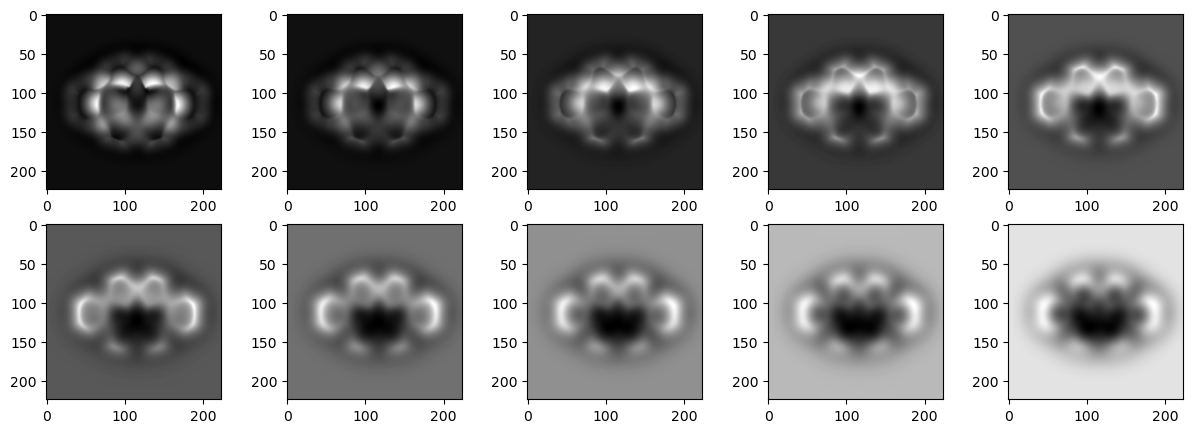

In [90]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.2, normalize=True)


#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [92]:
CID = 1234512345 
'C7=CC=C6C1=CC=C([N]1[H])C2=CC=C([N]2[H])C3=CC=CC=C3C4=CC=C([N]4)C5=CC=C([N]5)C6=C7'
SMILES = 'C1=c6nc(C1)c2CC=c(n2)c3ccccc3c4ccc([nH]4)c5ccc([nH]5)c7ccccc67'
cis_morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan
print(cis_morgan_fp.sum())


experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':cis_morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df

27


/tmp/ipykernel_3382761/3421578157.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H
0,/scratch/dataset/quam/K-1/Conformer3D_CID_1000...,10001048,C1=CC=C2C=C3C(=CC2=C1)NC(=N3)C4=CC5=C(C=C4)N=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,1.1767,25.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,16.0
1,/scratch/dataset/quam/K-1/Conformer3D_CID_1000...,10005,C(#N)N=C(N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0002,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0
2,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100128716,CC1=C(C2=NC(=CC(=C2C=C1)NCCCN)C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0110,15.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,21.0
3,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100175925,COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=CO2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0530,10.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,2.0,9.0
4,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100197007,COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC3=C(O2)C=CC4=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0856,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,2.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279844,/scratch/dataset/quam/K-1/Conformer3D_CID_3410...,341027,C1OC2=C(O1)C(=O)C3=C(C2=O)C=CC(=C3)O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0035,11.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,6.0
279845,/scratch/dataset/quam/K-1/Conformer3D_CID_5392...,53921077,C1=CC(=CC=C1C=N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0008,7.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0
279846,/scratch/dataset/quam/K-1/Conformer3D_CID_8238...,82382131,CC1=C2C=C(NC2=CC=C1)C3=NN=CC(=C3)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0034,14.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,11.0
279847,/scratch/dataset/quam/K-1/Conformer3D_CID_8241...,82418146,C1=C(N=C(O1)C=O)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0057,5.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,3.0


In [93]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
8


In [94]:
output_df = fp_screening_function(exp_fp, experimental_df, top_k=10)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

Is the correct CID in the top k candidates? False


,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H,tanimoto
30,/scratch/dataset/quam/K-1/Conformer3D_CID_1017...,101725283,C1=CC2=C3C=CC=C3C2=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0183,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.600000
112827,/scratch/dataset/quam/K-10/Conformer3D_CID_917...,9170,C1=CC=C2C(=C1)C3=CC=CC=C3C4=CC=CC=C24,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0017,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.600000
23588,/scratch/dataset/quam/K-3/Conformer3D_CID_1365...,136564,C1=CC=C2C(=C1)C3=CC=CC=C3C2=C4C5=CC=CC=C5C6=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0041,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.583333
169321,/scratch/dataset/quam/K-15/Conformer3D_CID_216...,21617700,C1=CC=C2C(=C1)C(=C2Cl)Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0021,8.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.538462
106150,/scratch/dataset/quam/K-10/Conformer3D_CID_678...,6780,C1=CC=C2C(=C1)C(=O)C3=CC=CC=C3C2=O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0014,14.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,8.0,0.538462
56382,/scratch/dataset/quam/K-5/Conformer3D_CID_2784...,278495,C1=CC=C2C(=C1)C(=C2O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0006,8.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,0.538462
94683,/scratch/dataset/quam/K-9/Conformer3D_CID_2050...,20500,C1=CC=C2C(=C1)C3=CC=CC=C3C2=N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0009,13.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0,0.500000
73509,/scratch/dataset/quam/K-7/Conformer3D_CID_7814...,78147,C=C1C2=CC=CC=C2C3=CC=CC=C13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0022,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.500000
72562,/scratch/dataset/quam/K-7/Conformer3D_CID_2981...,2981,C1=CC=C2C(=C1)C3=CC=CC=C3C(=N)C2=N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,1.1426,14.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.500000
97638,/scratch/dataset/quam/K-9/Conformer3D_CID_2497...,24975576,C1=CC=C2C(=C1)C3=CC=CC=C3NN2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0010,12.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.466667


In [95]:
output_df[output_df['CID'] == CID]

,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H,tanimoto


In [96]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        gt_fp = cis_morgan_fp
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))

Interpolation method: bilinear
zoom: 0.5 tanimoto 0.1
zoom: 0.6 tanimoto 0.1
zoom: 0.7 tanimoto 0.2
zoom: 0.8 tanimoto 0.01
zoom: 0.9 tanimoto 0.07
zoom: 1 tanimoto 0.14
zoom: 1.1 tanimoto 0.21
zoom: 1.2 tanimoto 0.17
zoom: 1.3 tanimoto 0.16
zoom: 1.4 tanimoto 0.12
zoom: 1.5 tanimoto 0.15
Interpolation method: nearest
zoom: 0.5 tanimoto 0.1
zoom: 0.6 tanimoto 0.1
zoom: 0.7 tanimoto 0.2
zoom: 0.8 tanimoto 0.01
zoom: 0.9 tanimoto 0.07
zoom: 1 tanimoto 0.14
zoom: 1.1 tanimoto 0.21
zoom: 1.2 tanimoto 0.17
zoom: 1.3 tanimoto 0.16
zoom: 1.4 tanimoto 0.12
zoom: 1.5 tanimoto 0.15
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.1
zoom: 0.6 tanimoto 0.1
zoom: 0.7 tanimoto 0.2
zoom: 0.8 tanimoto 0.01
zoom: 0.9 tanimoto 0.07
zoom: 1 tanimoto 0.14
zoom: 1.1 tanimoto 0.21
zoom: 1.2 tanimoto 0.17
zoom: 1.3 tanimoto 0.16
zoom: 1.4 tanimoto 0.12
zoom: 1.5 tanimoto 0.15


### mDBPc cis gas phase k14

In [63]:
path = f'/home/{USER}/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k14'
sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k14/Conformer3D_mDBPc_K080_Amp060_df_003_17.52.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k14/Conformer3D_mDBPc_K080_Amp060_df_004_17.62.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k14/Conformer3D_mDBPc_K080_Amp060_df_005_17.72.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k14/Conformer3D_mDBPc_K080_Amp060_df_006_17.82.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k14/Conformer3D_mDBPc_K080_Amp060_df_007_17.92.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k14/Conformer3D_mDBPc_K080_Amp060_df_008_18.02.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k14/Conformer3D_mDBPc_K080_Amp060_df_009_18.12.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_cis_gas_k14/Conformer3D_mDBPc_K080_Amp060_df_010_18.22.png',
 '/home/mgonzalez/simulated_imag

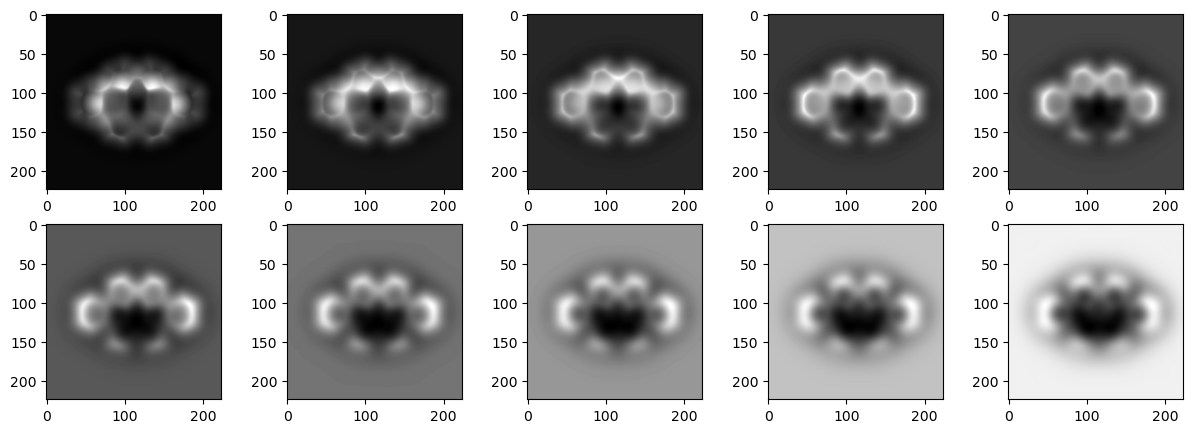

In [64]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.2, normalize=True)


#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [65]:
CID = 1234512345
SMILES = 'C7=CC=C6C1=CC=C([N]1[H])C2=CC=C([N]2[H])C3=CC=CC=C3C4=CC=C([N]4)C5=CC=C([N]5)C6=C7'
cis_morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan
print(cis_morgan_fp.sum())


experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':cis_morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df

24


/tmp/ipykernel_3382761/2760943738.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H
0,/scratch/dataset/quam/K-1/Conformer3D_CID_1000...,10001048,C1=CC=C2C=C3C(=CC2=C1)NC(=N3)C4=CC5=C(C=C4)N=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,1.1767,25.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,16.0
1,/scratch/dataset/quam/K-1/Conformer3D_CID_1000...,10005,C(#N)N=C(N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0002,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0
2,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100128716,CC1=C(C2=NC(=CC(=C2C=C1)NCCCN)C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0110,15.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,21.0
3,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100175925,COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=CO2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0530,10.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,2.0,9.0
4,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100197007,COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC3=C(O2)C=CC4=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0856,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,2.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279844,/scratch/dataset/quam/K-1/Conformer3D_CID_3410...,341027,C1OC2=C(O1)C(=O)C3=C(C2=O)C=CC(=C3)O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0035,11.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,6.0
279845,/scratch/dataset/quam/K-1/Conformer3D_CID_5392...,53921077,C1=CC(=CC=C1C=N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0008,7.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0
279846,/scratch/dataset/quam/K-1/Conformer3D_CID_8238...,82382131,CC1=C2C=C(NC2=CC=C1)C3=NN=CC(=C3)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0034,14.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,11.0
279847,/scratch/dataset/quam/K-1/Conformer3D_CID_8241...,82418146,C1=C(N=C(O1)C=O)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0057,5.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,3.0


In [66]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.2, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
9


In [67]:
output_df = fp_screening_function(exp_fp, experimental_df, top_k=10)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

Is the correct CID in the top k candidates? False


,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H,tanimoto
112827,/scratch/dataset/quam/K-10/Conformer3D_CID_917...,9170,C1=CC=C2C(=C1)C3=CC=CC=C3C4=CC=CC=C24,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0017,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.545455
30,/scratch/dataset/quam/K-1/Conformer3D_CID_1017...,101725283,C1=CC2=C3C=CC=C3C2=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0183,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.545455
23588,/scratch/dataset/quam/K-3/Conformer3D_CID_1365...,136564,C1=CC=C2C(=C1)C3=CC=CC=C3C2=C4C5=CC=CC=C5C6=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0041,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.538462
106150,/scratch/dataset/quam/K-10/Conformer3D_CID_678...,6780,C1=CC=C2C(=C1)C(=O)C3=CC=CC=C3C2=O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0014,14.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,8.0,0.500000
56382,/scratch/dataset/quam/K-5/Conformer3D_CID_2784...,278495,C1=CC=C2C(=C1)C(=C2O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0006,8.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,0.500000
169321,/scratch/dataset/quam/K-15/Conformer3D_CID_216...,21617700,C1=CC=C2C(=C1)C(=C2Cl)Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0021,8.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.500000
72562,/scratch/dataset/quam/K-7/Conformer3D_CID_2981...,2981,C1=CC=C2C(=C1)C3=CC=CC=C3C(=N)C2=N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,1.1426,14.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.466667
73509,/scratch/dataset/quam/K-7/Conformer3D_CID_7814...,78147,C=C1C2=CC=CC=C2C3=CC=CC=C13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0022,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.466667
94683,/scratch/dataset/quam/K-9/Conformer3D_CID_2050...,20500,C1=CC=C2C(=C1)C3=CC=CC=C3C2=N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0009,13.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0,0.466667
61364,/scratch/dataset/quam/K-6/Conformer3D_CID_3333...,3333137,C1=CC=C2C=C3C4=CC=CC=C4C3=CC2=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0006,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.437500


In [53]:
output_df[output_df['CID'] == CID]

,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H,tanimoto


In [68]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        gt_fp = cis_morgan_fp
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))

Interpolation method: bilinear
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.07
zoom: 0.7 tanimoto 0.1
zoom: 0.8 tanimoto 0.01
zoom: 0.9 tanimoto 0.05
zoom: 1 tanimoto 0.11
zoom: 1.1 tanimoto 0.14
zoom: 1.2 tanimoto 0.27
zoom: 1.3 tanimoto 0.25
zoom: 1.4 tanimoto 0.22
zoom: 1.5 tanimoto 0.21
Interpolation method: nearest
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.07
zoom: 0.7 tanimoto 0.1
zoom: 0.8 tanimoto 0.01
zoom: 0.9 tanimoto 0.05
zoom: 1 tanimoto 0.11
zoom: 1.1 tanimoto 0.14
zoom: 1.2 tanimoto 0.27
zoom: 1.3 tanimoto 0.25
zoom: 1.4 tanimoto 0.22
zoom: 1.5 tanimoto 0.21
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.07
zoom: 0.7 tanimoto 0.1
zoom: 0.8 tanimoto 0.01
zoom: 0.9 tanimoto 0.05
zoom: 1 tanimoto 0.11
zoom: 1.1 tanimoto 0.14
zoom: 1.2 tanimoto 0.27
zoom: 1.3 tanimoto 0.25
zoom: 1.4 tanimoto 0.22
zoom: 1.5 tanimoto 0.21


### mDBPc_Ag_cis_imgs

In [56]:
path = f'/home/{USER}/simulated_images/mDBPc/PREPROCESSED/mDBPc_Ag_cis_imgs_k1'
sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_Ag_cis_imgs/Conformer3D_mDBPc_K040_Amp040_df_003_17.52.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_Ag_cis_imgs/Conformer3D_mDBPc_K040_Amp040_df_004_17.62.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_Ag_cis_imgs/Conformer3D_mDBPc_K040_Amp040_df_005_17.72.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_Ag_cis_imgs/Conformer3D_mDBPc_K040_Amp040_df_006_17.82.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_Ag_cis_imgs/Conformer3D_mDBPc_K040_Amp040_df_007_17.92.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_Ag_cis_imgs/Conformer3D_mDBPc_K040_Amp040_df_008_18.02.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_Ag_cis_imgs/Conformer3D_mDBPc_K040_Amp040_df_009_18.12.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_Ag_cis_imgs/Conformer3D_mDBPc_K040_Amp040_df_010_18.22.png',
 '/home/mgonzalez/simulated_imag

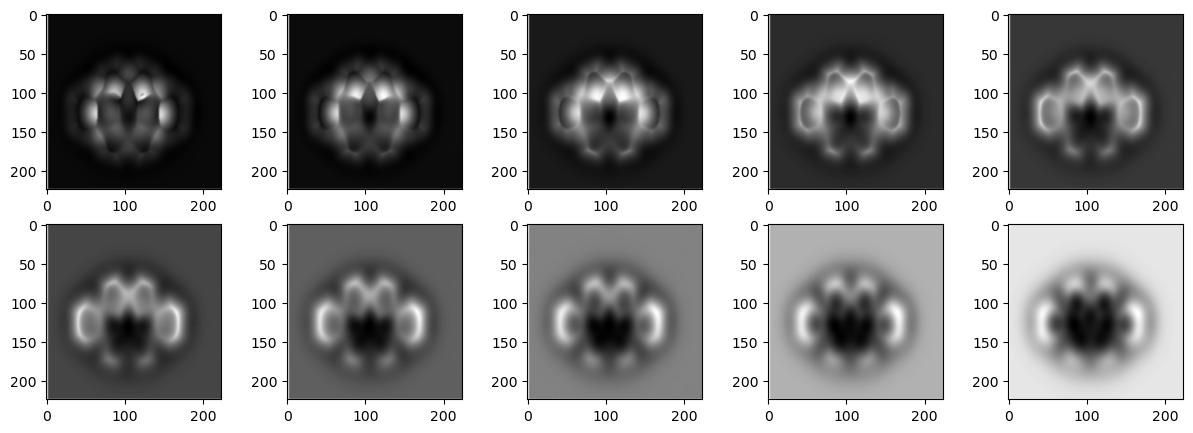

In [57]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.15, normalize=True)


#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [58]:
CID = 1234512345
SMILES = 'C7=CC=C6C1=CC=C([N]1[H])C2=CC=C([N]2[H])C3=CC=CC=C3C4=CC=C([N]4)C5=CC=C([N]5)C6=C7'
cis_morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan
print(cis_morgan_fp.sum())


experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':cis_morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df

24


/tmp/ipykernel_3382761/2760943738.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H
0,/scratch/dataset/quam/K-1/Conformer3D_CID_1000...,10001048,C1=CC=C2C=C3C(=CC2=C1)NC(=N3)C4=CC5=C(C=C4)N=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,1.1767,25.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,16.0
1,/scratch/dataset/quam/K-1/Conformer3D_CID_1000...,10005,C(#N)N=C(N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0002,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0
2,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100128716,CC1=C(C2=NC(=CC(=C2C=C1)NCCCN)C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0110,15.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,21.0
3,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100175925,COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=CO2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0530,10.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,2.0,9.0
4,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100197007,COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC3=C(O2)C=CC4=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0856,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,2.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279844,/scratch/dataset/quam/K-1/Conformer3D_CID_3410...,341027,C1OC2=C(O1)C(=O)C3=C(C2=O)C=CC(=C3)O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0035,11.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,6.0
279845,/scratch/dataset/quam/K-1/Conformer3D_CID_5392...,53921077,C1=CC(=CC=C1C=N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0008,7.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0
279846,/scratch/dataset/quam/K-1/Conformer3D_CID_8238...,82382131,CC1=C2C=C(NC2=CC=C1)C3=NN=CC(=C3)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0034,14.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,11.0
279847,/scratch/dataset/quam/K-1/Conformer3D_CID_8241...,82418146,C1=C(N=C(O1)C=O)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0057,5.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,3.0


In [59]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.2, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
16


In [60]:
output_df = fp_screening_function(exp_fp, experimental_df, top_k=10)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

Is the correct CID in the top k candidates? False


,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H,tanimoto
95486,/scratch/dataset/quam/K-9/Conformer3D_CID_2195...,21957114,C1=CC=C2C(=C1)ONO2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0515,6.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,5.0,0.304348
97638,/scratch/dataset/quam/K-9/Conformer3D_CID_2497...,24975576,C1=CC=C2C(=C1)C3=CC=CC=C3NN2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0010,12.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.304348
7219,/scratch/dataset/quam/K-1/Conformer3D_CID_1361...,13613743,C1=CC=C2C(=C1)C3=C4C5=CC=CC=C5C4=C6C7=CC=CC=C7...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0016,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.300000
26312,/scratch/dataset/quam/K-3/Conformer3D_CID_5957...,59575045,C1=CC=C2C3=CC=CC=C4C5=CC=CC=C6C7=CC=CC=C8C(=C1...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0024,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.300000
73497,/scratch/dataset/quam/K-7/Conformer3D_CID_7798...,77987,C1=CC=C2C=CC2=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0004,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.300000
1040,/scratch/dataset/quam/K-1/Conformer3D_CID_1302...,130275066,C1C2=C(COC3=CC=CC=C23)C4=CC=CC=C4O1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.6875,16.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,12.0,0.296296
83387,/scratch/dataset/quam/K-8/Conformer3D_CID_1174...,11745214,C1=CC=C2C(=C1)C(=S)NC2=S,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0013,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,5.0,0.291667
95806,/scratch/dataset/quam/K-9/Conformer3D_CID_2224...,22245515,C1=CC=C2C(=C1)C3=C(C4=CC=CC=C43)C5=C2C6=CC=CC=C65,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0026,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.285714
93907,/scratch/dataset/quam/K-9/Conformer3D_CID_1383...,138317,C1=CC=C2C(=C1)C3=CC=CC=C4C3=C2C5=CC=CC=C54,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0017,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.285714
23588,/scratch/dataset/quam/K-3/Conformer3D_CID_1365...,136564,C1=CC=C2C(=C1)C3=CC=CC=C3C2=C4C5=CC=CC=C5C6=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0041,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.285714


In [61]:
output_df[output_df['CID'] == CID]

,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H,tanimoto


In [62]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        gt_fp = cis_morgan_fp
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))

Interpolation method: bilinear
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.04
zoom: 0.7 tanimoto 0.09
zoom: 0.8 tanimoto 0.04
zoom: 0.9 tanimoto 0.0
zoom: 1 tanimoto 0.05
zoom: 1.1 tanimoto 0.1
zoom: 1.2 tanimoto 0.21
zoom: 1.3 tanimoto 0.21
zoom: 1.4 tanimoto 0.21
zoom: 1.5 tanimoto 0.21
Interpolation method: nearest
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.04
zoom: 0.7 tanimoto 0.09
zoom: 0.8 tanimoto 0.04
zoom: 0.9 tanimoto 0.0
zoom: 1 tanimoto 0.05
zoom: 1.1 tanimoto 0.1
zoom: 1.2 tanimoto 0.21
zoom: 1.3 tanimoto 0.21
zoom: 1.4 tanimoto 0.21
zoom: 1.5 tanimoto 0.21
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.04
zoom: 0.7 tanimoto 0.09
zoom: 0.8 tanimoto 0.04
zoom: 0.9 tanimoto 0.0
zoom: 1 tanimoto 0.05
zoom: 1.1 tanimoto 0.1
zoom: 1.2 tanimoto 0.21
zoom: 1.3 tanimoto 0.21
zoom: 1.4 tanimoto 0.21
zoom: 1.5 tanimoto 0.21


### mDBPc_NaCl_is_trans_pyFDBM_k1

In [72]:
path = f'/home/{USER}/simulated_images/mDBPc/PREPROCESSED/mDBPc_NaCl_is_trans_pyFDBM_k1'
sample_df = test_df
sorted(glob.glob(os.path.join(path,'*')))

['/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_NaCl_is_trans_pyFDBM_k1/mdbpc_nacl_trans_2.8000.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_NaCl_is_trans_pyFDBM_k1/mdbpc_nacl_trans_2.9000.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_NaCl_is_trans_pyFDBM_k1/mdbpc_nacl_trans_3.0000.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_NaCl_is_trans_pyFDBM_k1/mdbpc_nacl_trans_3.1000.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_NaCl_is_trans_pyFDBM_k1/mdbpc_nacl_trans_3.2000.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_NaCl_is_trans_pyFDBM_k1/mdbpc_nacl_trans_3.3000.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_NaCl_is_trans_pyFDBM_k1/mdbpc_nacl_trans_3.4000.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_NaCl_is_trans_pyFDBM_k1/mdbpc_nacl_trans_3.5000.png',
 '/home/mgonzalez/simulated_images/mDBPc/PREPROCESSED/mDBPc_NaCl_is_trans_pyFDBM_k1/mdbp

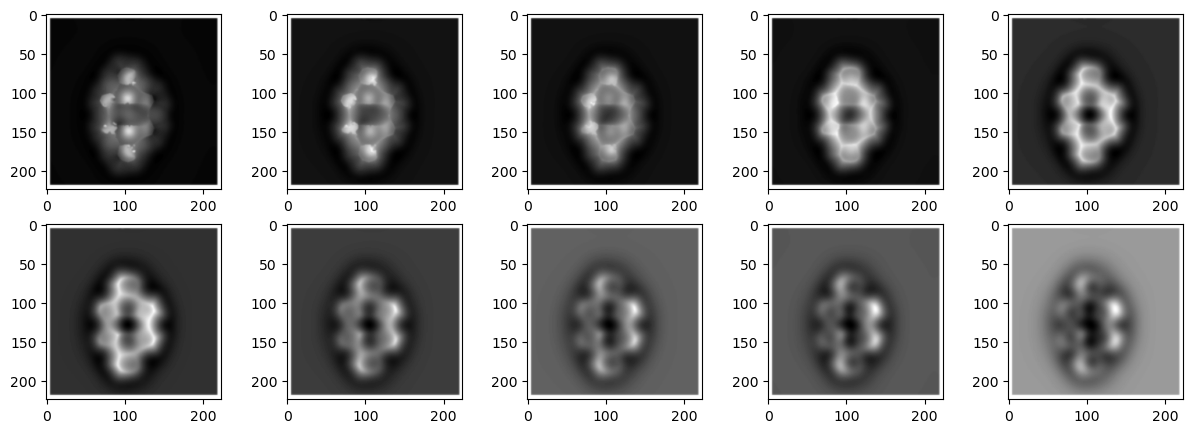

In [73]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.2, normalize=True)


#10 images
f, axarr = plt.subplots(2,5, figsize=(15, 5))
axarr[0,0].imshow(exp_img[0], cmap = 'gray')
axarr[0,1].imshow(exp_img[1], cmap = 'gray')
axarr[0,2].imshow(exp_img[2], cmap = 'gray')
axarr[0,3].imshow(exp_img[3], cmap = 'gray')
axarr[0,4].imshow(exp_img[4], cmap = 'gray')
axarr[1,0].imshow(exp_img[5], cmap = 'gray')
axarr[1,1].imshow(exp_img[6], cmap = 'gray')
axarr[1,2].imshow(exp_img[7], cmap = 'gray')
axarr[1,3].imshow(exp_img[8], cmap = 'gray')
axarr[1,4].imshow(exp_img[9], cmap = 'gray')

In [79]:
CID = 1234512345
trans_SMILES = "C7=CC=C6C1=CC=C([N]1[H])C2=CC=C([N]2)C3=CC=CC=C3C4=CC=C([N]4[H])C5=CC=C([N]5)C6=C7"
trans_morgan_fp = morgan_fp_gen(SMILES, nBits=1024)
split='test'
corrugation = np.nan
print(trans_morgan_fp.sum())


experimental_df = sample_df.append({'path':path,
                           'CID':CID, 
                           'SMILES':SMILES,
                           'morgan_fp':trans_morgan_fp,
                           'split':split,
                           'corrugation':corrugation
                            }, ignore_index=True)
experimental_df

24


/tmp/ipykernel_3382761/1611105129.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  experimental_df = sample_df.append({'path':path,


,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H
0,/scratch/dataset/quam/K-1/Conformer3D_CID_1000...,10001048,C1=CC=C2C=C3C(=CC2=C1)NC(=N3)C4=CC5=C(C=C4)N=C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,1.1767,25.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,16.0
1,/scratch/dataset/quam/K-1/Conformer3D_CID_1000...,10005,C(#N)N=C(N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0002,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0
2,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100128716,CC1=C(C2=NC(=CC(=C2C=C1)NCCCN)C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0110,15.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,21.0
3,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100175925,COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=CO2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0530,10.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,2.0,9.0
4,/scratch/dataset/quam/K-1/Conformer3D_CID_1001...,100197007,COC(=O)CSC1=NN=C(S1)NC(=O)C2=CC3=C(O2)C=CC4=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0856,18.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,2.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279844,/scratch/dataset/quam/K-1/Conformer3D_CID_3410...,341027,C1OC2=C(O1)C(=O)C3=C(C2=O)C=CC(=C3)O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0035,11.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,6.0
279845,/scratch/dataset/quam/K-1/Conformer3D_CID_5392...,53921077,C1=CC(=CC=C1C=N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0008,7.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0
279846,/scratch/dataset/quam/K-1/Conformer3D_CID_8238...,82382131,CC1=C2C=C(NC2=CC=C1)C3=NN=CC(=C3)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0034,14.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,11.0
279847,/scratch/dataset/quam/K-1/Conformer3D_CID_8241...,82418146,C1=C(N=C(O1)C=O)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0057,5.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,3.0


In [83]:
exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=1.5, normalize=True)
with torch.no_grad():
    batched_tensor = exp_img.unsqueeze(dim = 0).to(device)
    print(batched_tensor.size())
    predictions = model(batched_tensor)
    print(predictions.size())
    fp_pred = (torch.sigmoid(predictions) > 0.5)
    print(fp_pred.size())

exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()
print(exp_fp.shape)
print(exp_fp.sum())

torch.Size([1, 10, 224, 224])
torch.Size([1, 1024])
torch.Size([1, 1024])
(1024,)
12


In [84]:
output_df = fp_screening_function(exp_fp, experimental_df, top_k=10)

print('Is the correct CID in the top k candidates?',  CID in list(output_df['CID']))
output_df

Is the correct CID in the top k candidates? False


,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H,tanimoto
30,/scratch/dataset/quam/K-1/Conformer3D_CID_1017...,101725283,C1=CC2=C3C=CC=C3C2=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0183,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.428571
97638,/scratch/dataset/quam/K-9/Conformer3D_CID_2497...,24975576,C1=CC=C2C(=C1)C3=CC=CC=C3NN2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0010,12.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.368421
23588,/scratch/dataset/quam/K-3/Conformer3D_CID_1365...,136564,C1=CC=C2C(=C1)C3=CC=CC=C3C2=C4C5=CC=CC=C5C6=CC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0041,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.352941
83387,/scratch/dataset/quam/K-8/Conformer3D_CID_1174...,11745214,C1=CC=C2C(=C1)C(=S)NC2=S,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0013,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,5.0,0.350000
61175,/scratch/dataset/quam/K-6/Conformer3D_CID_1911...,191109,C1=CC=C2C(=C1)C=NC2=O,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0005,8.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.333333
84092,/scratch/dataset/quam/K-8/Conformer3D_CID_1220...,12206441,C1=CC=C(C=C1)C2=NC3=CC=CC=C32,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0006,13.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0,0.333333
23696,/scratch/dataset/quam/K-3/Conformer3D_CID_5869...,58690090,C1=CC2=C3C(=C1)C4=C5C36C7=C2C=CC=C7C8=C6C(=CC=...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.9804,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.333333
106150,/scratch/dataset/quam/K-10/Conformer3D_CID_678...,6780,C1=CC=C2C(=C1)C(=O)C3=CC=CC=C3C2=O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0014,14.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,8.0,0.333333
40048,/scratch/dataset/quam/K-4/Conformer3D_CID_1298...,129803933,C1=CC2=C3C(=C1)C4=C(C3=CC=C2)C=C4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0015,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.333333
56382,/scratch/dataset/quam/K-5/Conformer3D_CID_2784...,278495,C1=CC=C2C(=C1)C(=C2O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",test,0.0006,8.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,0.333333


In [82]:
output_df[output_df['CID'] == CID]

,path,CID,SMILES,morgan_fp,split,corrugation,C,Br,Cl,F,I,N,O,P,S,H,tanimoto


In [78]:
for interpolation_method in ['bilinear', 'nearest', 'bicubic']:
    print(f'Interpolation method: {interpolation_method}')
    for zoom in [ 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]:
        exp_img = load_exp_img_stack(path, dimensions = [224,224], zoom=zoom, interpolation=interpolation_method)
        with torch.no_grad():
            batched_tensor = exp_img.unsqueeze(dim = 0).to(device)

            predictions = model(batched_tensor)

            fp_pred = (torch.sigmoid(predictions) > 0.5)


        exp_fp = fp_pred.cpu().numpy().astype(int).squeeze()

        gt_fp = cis_morgan_fp
        
        print('zoom:', zoom, 'tanimoto', round(tanimoto_numpy(exp_fp.squeeze(), gt_fp), 2))

Interpolation method: bilinear
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.19
zoom: 0.7 tanimoto 0.12
zoom: 0.8 tanimoto 0.06
zoom: 0.9 tanimoto 0.01
zoom: 1 tanimoto 0.0
zoom: 1.1 tanimoto 0.15
zoom: 1.2 tanimoto 0.19
zoom: 1.3 tanimoto 0.26
zoom: 1.4 tanimoto 0.25
zoom: 1.5 tanimoto 0.29
Interpolation method: nearest
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.19
zoom: 0.7 tanimoto 0.12
zoom: 0.8 tanimoto 0.06
zoom: 0.9 tanimoto 0.01
zoom: 1 tanimoto 0.0
zoom: 1.1 tanimoto 0.15
zoom: 1.2 tanimoto 0.19
zoom: 1.3 tanimoto 0.26
zoom: 1.4 tanimoto 0.25
zoom: 1.5 tanimoto 0.29
Interpolation method: bicubic
zoom: 0.5 tanimoto 0.11
zoom: 0.6 tanimoto 0.19
zoom: 0.7 tanimoto 0.12
zoom: 0.8 tanimoto 0.06
zoom: 0.9 tanimoto 0.01
zoom: 1 tanimoto 0.0
zoom: 1.1 tanimoto 0.15
zoom: 1.2 tanimoto 0.19
zoom: 1.3 tanimoto 0.26
zoom: 1.4 tanimoto 0.25
zoom: 1.5 tanimoto 0.29
